In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
from keras.utils import plot_model

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('./data_1/data.csv',index_col=0)
df.shape

(17745, 100)

In [5]:
float_data = df.values

In [6]:
df.values

array([[ 0.        ,  0.        ,  5.56410256, ..., 10.43269231,
         0.30288462,  0.        ],
       [ 0.        ,  0.        ,  3.43269231, ..., 16.07051282,
         0.8125    ,  0.        ],
       [ 0.        ,  0.        ,  2.94871795, ..., 21.40865385,
         1.27403846,  0.        ],
       ...,
       [ 0.        ,  0.        ,  1.65865385, ...,  7.85737179,
         0.29326923,  0.        ],
       [ 0.        ,  0.        ,  1.28044872, ...,  4.16666667,
         0.12820513,  0.        ],
       [ 0.        ,  0.        ,  3.35897436, ..., 12.08974359,
         0.60096154,  0.        ]])

For instance, here is the plot of temperature (in degrees Celsius) over time:

In [7]:
from matplotlib import pyplot as plt

temp = float_data[:, 6]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

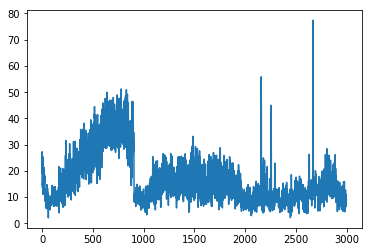

In [8]:
plt.plot(range(3000),temp[:3000])
plt.show() 

In [9]:
mean = float_data.mean(axis=0)
float_data -= mean


In [10]:
std = float_data.std(axis=0)
index = (std == 0.0)
std[index] = 1
float_data /= std

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),100))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0:]
        yield samples, targets

In [12]:
lookback = 100
step = 1
delay = 1
batch_size = 32

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=15705,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=15705,
                    max_index=16742,
                  shuffle=True,

                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                       shuffle=True,

                     min_index=16742,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

train_steps = 15705//batch_size
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (16742 - 15705 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 16742 - lookback) // batch_size

In [13]:
train_steps

490

In [14]:
# def evaluate_naive_method():
#     batch_maes = []
#     for step in range(val_steps):
#         samples, targets = next(val_gen)
#         preds = samples[:, -1, 1]
#         mae = np.mean(np.abs(preds - targets))
#         batch_maes.append(mae)
#     print(np.mean(batch_maes))
    
# evaluate_naive_method()

In [15]:
# std[0]*0.5585113938187948


In [16]:
np.sum(std*0.3432)/100

2.5923554545365675

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,SGD,Adagrad

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(100))

model.compile(optimizer=Adagrad(lr=0.01, epsilon=None, decay=0.0), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=1,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/1
490/490 [==============================] - 7s 14ms/step - loss: 0.9174 - val_loss: 0.5305


In [19]:
plot_model(model,show_shapes=True,to_file='model.png')

OSError: `pydotplus` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

Let's display the loss curves for validation and training:

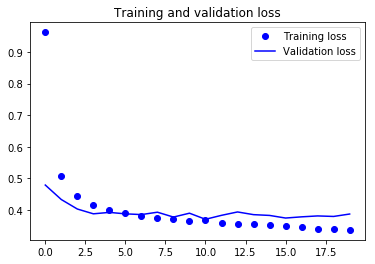

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(100))

model.compile(optimizer=Adagrad(lr=0.01, epsilon=None, decay=0.0), loss='mse')
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
490/490 [==============================] - 32s 65ms/step - loss: 0.4961 - val_loss: 0.4236
Epoch 2/20
490/490 [==============================] - 31s 64ms/step - loss: 0.4508 - val_loss: 0.3591
Epoch 3/20
490/490 [==============================] - 29s 59ms/step - loss: 0.4371 - val_loss: 0.3866
Epoch 4/20
490/490 [==============================] - 29s 60ms/step - loss: 0.4393 - val_loss: 0.4078
Epoch 5/20
490/490 [==============================] - 37s 76ms/step - loss: 0.4273 - val_loss: 0.3640
Epoch 6/20
490/490 [==============================] - 36s 73ms/step - loss: 0.4333 - val_loss: 0.3634
Epoch 7/20
490/490 [==============================] - 34s 69ms/step - loss: 0.4186 - val_loss: 0.3691
Epoch 8/20
490/490 [==============================] - 31s 63ms/step - loss: 0.4149 - val_loss: 0.3475
Epoch 9/20
490/490 [==============================] - 31s 64ms/step - loss: 0.4217 - val_loss: 0.3680
Epoch 10/20
490/490 [==============================] - 30s 61ms/step - loss: 0.418

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3300      
Total params: 16,068
Trainable params: 16,068
Non-trainable params: 0
_________________________________________________________________


Let look at our results:

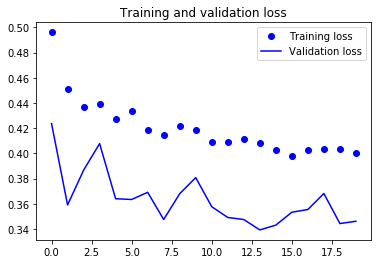

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(100))

model.compile(optimizer=RMSprop(), loss='mse')
# history = model.fit_generator(train_gen,
#                               steps_per_epoch=train_steps,
#                               epochs=30,
#                               validation_data=val_gen,
#                               validation_steps=val_steps)

NameError: name 'float_data' is not defined

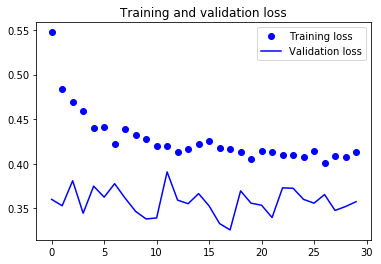

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(100))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

NameError: name 'float_data' is not defined

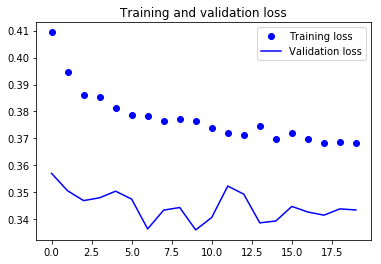

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
import cv2
import os
import re
import pandas as pd
path = './data_1/1115-9/1/txt'
data = []
df = pd.DataFrame()
for i in os.listdir(path):
    dict1 = {}
    with open(path+'/'+i) as f:
        data = f.read()
        col = int(data.split(' ')[0].split(':')[1])

        row = int(data.split(' ')[1].split(':')[1])
        T = data.split(' ')[7].split(':')[1]
        img = cv2.imread("./data_1/1115-9/1/bmp/"+re.sub('txt','bmp',i), 0)
        x = img[row][col]
        y = float(T)
        dict1['x'] = x
        dict1['y'] = y
        df = df.append(dict1, ignore_index=True)
df.to_csv('temperature.csv')

